### Linked tables implementation

Syngen is capable of training multiple related tables sharing a key. The relations between tables should be specified in yaml metadata file.

In [28]:
import requests
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
dataset_pk = requests.get("https://raw.githubusercontent.com/tdspora/syngen/main/example-data/housing_pk.csv")
dataset_fk = requests.get("https://raw.githubusercontent.com/tdspora/syngen/main/example-data/housing_fk.csv")
metadata = requests.get("https://raw.githubusercontent.com/tdspora/syngen/main/example-data/housing.yml")

In [4]:
with open("housing_pk.csv", "w+") as file:
    file.write(dataset_pk.content.decode("utf-8"))
with open("housing_fk.csv", "w+") as file:
    file.write(dataset_fk.content.decode("utf-8"))
with open("housing.yml", "w+") as file:
    file.write(metadata.content.decode("utf-8"))

Let's inspect the format of metadata file

In [5]:
from yaml import load
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader, Dumper
import json

In [18]:
with open("housing.yml", "r") as metadata:
    housing_metadata = load(metadata, Loader)

# Do this to pretty print the dictionary
print(json.dumps(housing_metadata, sort_keys=False, indent=2))

{
  "pk_test": {
    "source": "./housing_pk.csv",
    "train_settings": {
      "epochs": 10
    },
    "keys": {
      "house_id": {
        "type": "PK",
        "columns": [
          "house_id"
        ]
      }
    },
    "infer_settings": {
      "size": 10000,
      "print_report": false
    }
  },
  "fk_test": {
    "source": "./housing_fk.csv",
    "train_settings": {
      "epochs": 10
    },
    "keys": {
      "house_id": {
        "type": "FK",
        "columns": [
          "house_id"
        ],
        "references": {
          "table": "pk_test",
          "columns": [
            "house_id"
          ]
        }
      }
    },
    "infer_settings": {
      "size": 10000,
      "print_report": false
    }
  }
}


Also we can ckech the distribution of PK and FK values in the original data.

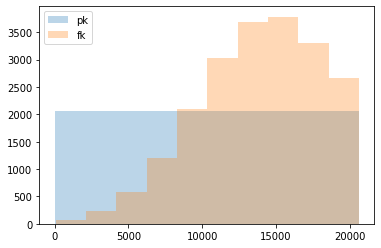

In [41]:
housing_pk = pd.read_csv("housing_pk.csv")
housing_fk = pd.read_csv("housing_fk.csv")
plt.hist(housing_pk.house_id, alpha=0.3, label="pk")
plt.hist(housing_fk.house_id, alpha=0.3, label="fk")
plt.legend()

In [8]:
%%cmd

python.exe -m pip install --upgrade pip
pip3 install syngen

Microsoft Windows [Version 10.0.19044.2251]
(c) Microsoft Corporation. All rights reserved.

C:\Users\Pavel_Bobyrev>
C:\Users\Pavel_Bobyrev>python.exe -m pip install --upgrade pip

C:\Users\Pavel_Bobyrev>pip3 install syngen
     ---------------------------------------- 63.9/63.9 kB 1.1 MB/s eta 0:00:00

C:\Users\Pavel_Bobyrev>

Then we will invoke the training process. To demonstrate the early stopping feature we subset a small amount of rows from the table (2048) using row_limit argument.

In [19]:
%%cmd

train --metadata_path "housing.yml"

Microsoft Windows [Version 10.0.19044.2251]
(c) Microsoft Corporation. All rights reserved.

C:\Users\Pavel_Bobyrev>
C:\Users\Pavel_Bobyrev>train --metadata_path "housing.yml"


2022-12-01 08:28:53.440 | INFO     | syngen.ml.validation_schema.validation_schema:validate_schema:45 - The schema of metadata file is valid
2022-12-01 08:28:53.440 | INFO     | syngen.ml.worker.worker:__train_chain_of_tables:146 - Training process of the table - pk_test has started.
2022-12-01 08:28:53.458 | INFO     | syngen.ml.interface.interface:run:147 - Generator: 'vae', mode: 'train'
2022-12-01 08:28:53.458 | DEBUG    | syngen.ml.strategies.strategies:run:27 - Train model with parameters: epochs=10, drop_null=False
2022-12-01 08:28:53.534 | DEBUG    | syngen.ml.pipeline.pipeline:data_pipeline:128 - Count of string columns: 0; Count of float columns: 2; Count of int columns: 1; Count of categorical columns: 0; Count of date columns: 0; Count of binary columns: 0
2022-12-01 08:28:55.659 | INFO     | syngen.ml.reporters.reporters:report:158 - Corresponding plot pickle files regarding to sampled data accuracy test were saved to folder 'model_artifacts/tmp_store/pk_test/draws/'.
2022


C:\Users\Pavel_Bobyrev>

Pay attention, that all parameters from training and inference are specified in the metadata file. All you need is to pass the path to metadata asargument to both train and infer commands

In [21]:
%%cmd

infer --metadata_path "housing.yml" --run_parallel false

Microsoft Windows [Version 10.0.19044.2251]
(c) Microsoft Corporation. All rights reserved.

C:\Users\Pavel_Bobyrev>
C:\Users\Pavel_Bobyrev>infer --metadata_path "housing.yml" --run_parallel false


2022-12-01 08:58:52.420 | INFO     | syngen.ml.validation_schema.validation_schema:validate_schema:45 - The schema of metadata file is valid
2022-12-01 08:58:52.420 | INFO     | syngen.ml.worker.worker:__infer_chain_of_tables:168 - Infer process of the table - pk_test has started.
2022-12-01 08:58:52.421 | INFO     | syngen.ml.train_chain.train_chain:handle:282 - Total of 1 batch(es)
2022-12-01 08:58:52.421 | INFO     | syngen.ml.train_chain.train_chain:run:204 - Start data synthesis
2022-12-01 08:58:52.698 | INFO     | syngen.ml.vae.wrappers.wrappers:load_state:303 - Loaded VAE state from model_artifacts/resources/pk_test/vae/checkpoints
2022-12-01 08:58:53.228 | INFO     | syngen.ml.train_chain.train_chain:handle:304 - Synthesis of the table - pk_test was completed. Synthetic data saved in model_artifacts/tmp_store/pk_test/merged_infer_pk_test.csv
2022-12-01 08:58:53.228 | INFO     | syngen.ml.worker.worker:__infer_chain_of_tables:168 - Infer process of the table - fk_test has starte


C:\Users\Pavel_Bobyrev>

When the inference process is completed you will see the log message "Synthesis of the table - housing was complited. Synthetic data saved in model_artifacts/tmp_store/housing/merged_infer_housing.csv".

That's it! You can find the generated table in the path mentioned above. Let's take a quick glance on the data generated using pandas/

In [23]:
import pandas as pd
housing_pk_synth = pd.read_csv("./model_artifacts/tmp_store/pk_test/merged_infer_pk_test.csv")
housing_fk_synth = pd.read_csv("./model_artifacts/tmp_store/fk_test/merged_infer_fk_test.csv")

In [26]:
housing_pk_synth.head()

,longitude,latitude,house_id
0,-117.297974,34.188610,1
1,-121.246109,37.631279,2
2,-119.179214,34.285744,3
3,-117.969849,33.881950,4
4,-118.341255,34.113895,5


In [27]:
housing_fk_synth.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,house_id
0,1,3403,484.0,1524,576,5.821095,174728,INLAND,3677
1,24,2763,567.0,1742,696,3.130805,72542,<1H OCEAN,8701
2,30,3873,713.0,2180,722,3.736773,133915,NEAR OCEAN,8913
3,35,2166,394.0,1184,538,4.729632,216947,<1H OCEAN,6615
4,40,1613,388.0,973,554,6.983237,254557,NEAR BAY,9678


Let's check the constrains for PK and referential integrity.

In [33]:
print("All PK values are unique:", housing_pk_synth.house_id.nunique() == len(housing_pk_synth))

All PK values are unique: True


In [35]:
print("All FK values have corresponding PKs:", sum(housing_fk_synth.house_id.isin(housing_pk_synth.house_id)) == len(housing_fk_synth))

All FK values have corresponding PKs: True


Finally, let's check the distribution of the keys. Since the keys generation approach is purely statistical, the possible correlations between tables will not be preserved. However, the distribution of FK will replicate the original one.

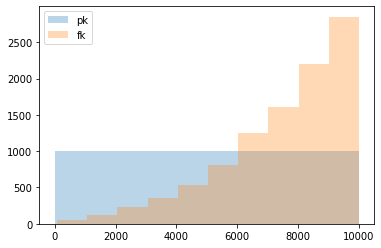

In [39]:
plt.hist(housing_pk_synth.house_id, alpha=0.3, label="pk")
plt.hist(housing_fk_synth.house_id, alpha=0.3, label="fk")
plt.legend()

The primary keys is replaced with range of values from 1 to len(table), so the distribution of generated PK will always be uniform. However, the FK distribution tryes to maximize its likelihood to the original distribution with given PKs.